In this notebook, we simulate the following stochastic process:
* Geoemetric Brownian Motion
* Square Root Diffustion
* Hetson Volitility Model
* Jump Diffusion Model


**Geoemetric Brownian Motion**The model is 
$$dS = \mu Sdt + \sigma S dw$$
Using Euler method, 
$$S_{t+\Delta t} = S_t +\mu \cdot S_t\cdot \Delta t + \sigma \cdot   \sqrt{\Delta t} \cdot z $$


In [8]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

############# Euler method for Geometric Brownian Motion ##########

'''
    parameters:
    ===========================
    S0:       current stock price
    mu:       expected return rate
    sigma:    varaince of stock price
    M:        number of subintervals
    T:        maturity time
    
'''

def GBM(S0, mu, sigma, T, M, num_of_iter):
    
    dt = float(T)/M
    
    #matrix of stock price, M rows, num_of_iter cols
    s = np.zeros((M+1, num_of_iter))
    
    s[0] = S0
    for t in range(1, M+1):
        s[t] = s[t-1] +mu*s[t-1]*dt \
        + sigma*np.sqrt(dt)*npr.standard_normal(num_of_iter)
        
    return s
        

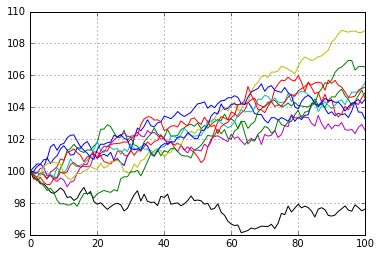

In [17]:
S0 = 100
mu = 0.02
sigma = 2
T = 2
num_of_iter = 20
M = 100
s = GBM(S0, mu, sigma, T, M, num_of_iter)

plt.plot(s[:, :10])
plt.grid(True)


**Square Root Diffusion**
We consider the following model due to Cox-Ross-Rubinstein
$$dx = a(b-x)dt +\sigma \sqrt{x}dw$$
First we consider the Euler method, approximating $x$ by its first order derivatives. 
$$x_{t+\Delta t} =x_t + a(b-x^+_t)\cdot \Delta t + \sigma \cdot  \sqrt{x^+_t} \cdot \sqrt{\Delta t} \cdot z $$
where $x^+_t$ is max $(0, x^+_t)$. I guess we need to take is because 
this diffusion process has reversoin properties.

In [54]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

############# Euler method for Square Root diffusion ##########

def srd(x0, a,b,sigma, T,M, num_of_iter):
    
    ''' 
    parameters
    ==========
    x0: initial value 
    
    a: reversion coeff
    
    b: long term mean
    
    M: number of subintervals
    
    '''
    dt = float(T)/M
    
    x = np.zeros((M+1, num_of_iter))
    x[0] = x0 
    
    for t in range(1, M+1):
        x[t] = x[t-1] + a*(b-np.maximum(x[t-1], 0))*dt \
               +sigma*np.sqrt(np.maximum(x[t-1],0))*np.sqrt(dt)\
               *npr.standard_normal(num_of_iter)
    
    #since square root diffusion has reversoin property, 
    # we only take positive values
    
    x1 = np.maximum(x, 0)
    
    return x1
    
    

In [57]:
x0 = 0.05
a = 3
b = 0.02
sigma = 0.1
T = 5
M = 50
num_of_iter = 50

x = srd(x0, a,b,sigma, T,M, num_of_iter)


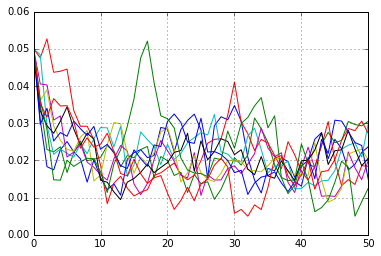

In [58]:
# We plot the first 10 simulation, note that
#when the value is approximating 0, it will move back
#moreover, when t is large the value is very close to b
plt.plot(x[:, :10])
plt.grid(True)

**Heston volitility model**
A good property of square root diffusion model is that the 
value will not be negative. So we can use it to model the volitility,
$$dS_t = \mu S_t dt + \sqrt{v_t}S_tdZ_t^1$$
$$dv_t = a(b-v_t)dt + \sqrt{v_t}\sigma_v dZ_t^2$$
$$dZ^1_t dZ_t^2 = \rho$$

To use Monte Carlo method, the crucial point is we need to generate 
two standard normal random with corelation equal to $\rho$.
To achieve this, we first generate two independent $x_1$ and $x_2$
then let 
$$ Z_1 = x_1$$ and 
$$ Z_2 = \rho x_1 + \sqrt{1-\rho ^2} x_2$$
It's easy to see $cor(Z_1, Z_2) = \rho.$
A more generla method is using Cholesky decompostion of the matrix
$$
\left(\begin{array}{cc} 
1 & \rho\\
\rho & 1
\end{array}\right)
$$
we get the lower triangle 
$$
L=\left(\begin{array}{cc} 
1 & 0\\
\rho & \sqrt{1-\rho ^2}
\end{array}\right)
$$

In [102]:

def hetson(S0, V0, mu, a, b, sigma_v, rho, T, M, num_of_iter):
    '''
    parameters
    ===========
    S0:     initial stock price
    V0:     initial volitility
    mu:     average return of stock 
    a:      reversion coeff
    b:      long term mean
    sigma:  standard deviation of volitility 
    rho:    corelation of the brownian motion of S and V
    '''
    
    #generate x1 and x2 then transform to Z1 and Z2
    #we actually need (2, M, num_of_iter) random variables
    #Z1 = rand[0] and Z2 = rand[1]
    rand = npr.standard_normal((2, M+1, num_of_iter))
    rand[1] = rho*rand[0]+ np.sqrt(1-rho**2)*rand[1]
    
    #matrix of variance, move M steps, generate num_of_iter times
    v = np.zeros((M+1, num_of_iter))
    v[0] = V0
    
    #matrix of stock price, move M steps, generate num_of_iter times
    S = np.zeros_like(v)
    S[0] = S0
    
    #generate variance
    dt = float(T)/M
    for t in range(1, M+1):
        v[t] =  v[t-1] + a*(b-np.maximum(v[t-1],0))*dt\
                       + sigma_v*np.sqrt(np.maximum(v[t-1],0))*np.sqrt(dt)*rand[1,t, :]     
    
    for t in range(1, M+1):
        S[t] = S[t-1]*np.exp((mu - 0.5*v[t])*dt+np.sqrt(np.maximum(v[t],0))\
                       *np.sqrt(dt)*rand[0,t, :] )
    return np.array((S,v))

In [103]:
S0 = 100
mu = 0.05
V0 = 0.1
a = 3.0
b = 0.25
sigma_v = 0.1
rho = 0.6
T = 1.0
M = 50
num_of_iter = 10000
H = hetson(S0, V0, mu, a, b, sigma_v, rho, T, M, num_of_iter)

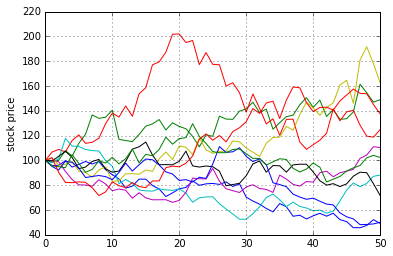

In [109]:
#we plot first 10 iteration of stock price
plt.plot(H[0][:, :10])
plt.grid(True)
plt.ylabel('stock price')

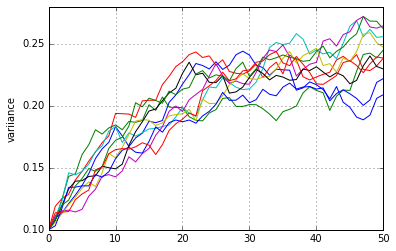

In [110]:
#we plot first 10 iteration of variance
plt.plot(H[1][:, :10])
plt.grid(True)
plt.ylabel('variiance')

** Jump diffusion model **
Assuming there are some jumps of the stock price, then the Jump-Diffusion SDE is 
\begin{equation*}
\frac{dS(t)}{S(t-)} = \mu dt +\sigma dW+dJ(t),
\end{equation*}
where 
\begin{equation*}
S(t-) = \lim _{\tau \rightarrow t^-}S(\tau)
\end{equation*}
and   the jump process.
\begin{equation*}
J(t) = \sum_{j=1}^{N(t)}(Y_j-1),
\end{equation*}
where $$N(t) = \sup \{n\mid \tau _n \le t\}$$ which is a counting process. 
We assume the jumps will happen at 
\begin{equation*}
0< \tau_1<\tau_2<\cdots<\tau_N
\end{equation*} following Possion process 
and $Y_j$ are random variables with positive values.
Following Merton's original assumption, 
we assume
$$ Y_j \sim \mbox{log normal}(a,b^2) $$

To justify the assumption of $Y_j$ note that
\begin{eqnarray*}
dJ(t) &=& 0 \mbox{  if }  t  \mbox{ is not equal to any of } \tau_j\\
&=& Y_j-1 \mbox{ if } t = \tau_j 
\end{eqnarray*}
Then according to the jump diffusion model 
\begin{eqnarray*}
&& S(\tau_j)-S(\tau_j-)=  (Y_j-1)\cdot S(\tau_j-)\\
&\Rightarrow& \frac{S(\tau_j)}{S(\tau_j-)} = Y_j
\end{eqnarray*}
That is, $Y_j$ is the ratio of stock prices before and after the jump.


The solution of the jump diffusion model is 
\begin{equation*}
S(t) = S(0)e^{(\mu - \frac{1}{2}\sigma ^2)t +\sigma w  }\prod _{j=1}^{ N(t)} Y_j
\end{equation*}

** Risk neutral measure **
We want to change the measure so that $S(t)e^{-rt}$ is a martingale. 
To this aim, we note that $N(t)-\lambda t$ is a martingale. More generally, 
$$ J(t) - \lambda (E(Y_j)-1) t $$
is a martingale.
Then the following SDE is a martingale
$$\frac{dS(t)}{S(t-)} = r dt +\sigma dW+[dJ(t)- \lambda (E(Y_j)-1) dt ]$$
Recall that under Merton's assumption,
$$ E(Y_j) = e^{a + \frac{b^2}{2}}$$
So if we let 
$$ r_J = \lambda (e^{a + \frac{b^2}{2}}-1)$$
the Euler schema of the stock price is 
$$ S_{t+1} = S_t (e^{(r-r_J-\frac{\sigma ^2}{2})\Delta t + \sigma \sqrt{\Delta t} z_1} + (e^{a+ bz_2}-1) p(\lambda, \delta t)),       $$
where $P(\lambda, \delta t)$ is Poisson.

In [16]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

def jump(S0,r,sigma, a, b, lambda_, T, M, num_iter):
    '''
    S0   : stock price today
    r    : risk free interest rate
    a, b : Assume the jump Y ~ log normal (a, b^2)
    lambda_: occurence of jumps follows Posisson with lambda_,
             during "one period"
    M    : numer of Euler steps
    
    '''

    #compute jump return r_J, to make discounted S martingale
    r_J = lambda_*(np.exp(a + b**2/2)-1)
    
    dt = float(T)/M
    S = np.zeros((M+1, num_of_iter))
    S[0] = S0
    for i in range(1, M+1):
        S[i] = S[i-1]*np.exp((r-r_J-sigma**2/2)*dt+ \
               sigma* np.sqrt(dt)*npr.standard_normal(num_iter))+\
               S[i-1]*(np.exp(a+ b*npr.standard_normal(num_iter))-1)*\
               npr.poisson(lambda_*dt, num_iter)

    return S         

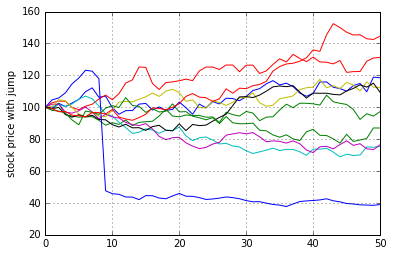

In [22]:
S0 = 100
r = 0.05
sigma = 0.2
a = -1.0
b = 0.2
lambda_ = 0.05
T = 1.0
M = 50
num_iter = 100
J = jump(S0,r,sigma, a, b, lambda_, T, M, num_iter)
plt.plot(J[:, :10])
plt.grid(True)
plt.ylabel('stock price with jump')